# Gesture Recognition


## Problem Statement

A home electronics company which manufactures state of the art smart televisions want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

 - Thumbs up:  Increase the volume
 - Thumbs down: Decrease the volume
 - Left swipe: 'Jump' backwards 10 seconds
 - Right swipe: 'Jump' forward 10 seconds  
 - Stop: Pause the movie

### methods used

## Importing libraries

In [26]:
import numpy as np
import os
from skimage import io
from skimage.transform import rescale, resize
import datetime
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [27]:
np.random.seed(30)
rn.seed(30)

In [28]:
#the main folder which contains train val folders and also .csv files
parent_folder = '.\Project_data\Project_data'

train_folder = parent_folder + '\\train'
val_folder = parent_folder + '\\val'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [29]:
train_doc = np.random.permutation(open(parent_folder + '\\train.csv').readlines())
val_doc = np.random.permutation(open(parent_folder + '\\val.csv').readlines())
batch_size = 32

enable_augmentation = False 
seq_idx = range(7,26,2)

dim_x, dim_y = 120, 120

In [30]:
datagen = ImageDataGenerator(brightness_range=[0.2,1.0],rotation_range=15,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,fill_mode="nearest")

In [31]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [32]:
#function to generate cropped images
def crop_image(image):
     if image.shape[1] > image.shape[0]:
        diff_px = image.shape[1] - image.shape[0]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[0]
        image = image[:, crop_start:crop_end]
     elif image.shape[0] > image.shape[1]:
        diff_px = image.shape[0] - image.shape[1]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[1]
        image = image[:, crop_start:crop_end]

     return image

## Writing our own Generator
generators are used beacause in prohects the datatype can be very very large like imageNet,AlexNet which runs in gegabytes and we wont be able to load entire data into main memory.sogenerators bring only required data into memory and process.

In [33]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmentation = False, debug=False):
    img_idx =  seq_idx #images to read
    #x reads the length
    x = len(img_idx)
    #initializing y to dim_x and z to dim_y
    y, z = dim_x, dim_y
    
    while True:
        if is_train and augmentation:
            #random permutaion takes shuffled images like some random image and it is concatinating both the folders list
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        # we iterate over the number of batches    
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,x,y,z,3))# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB 
            batch_labels = np.zeros((batch_size,5)) # performing one hot encoding
            for folder in range(batch_size):# iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
              
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) 
               
                for idx,item in enumerate(img_idx): 
                    filename = source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]
                    image = io.imread(filename).astype(np.float32)

                    if debug:
                        plt.subplot(2, x, idx+1)
                        #uint8 means it is an unsigned integer which has non-negetive values and colors are always non-negetive
                        plt.imshow(image.astype('uint8'))
                    #cropping the image
                    image = crop_image(image=image)
                    #resizing the image
                    resized_im = resize(image, output_shape=(120,120))
                
                    if augmentation==True and is_train==True:
                        resized_im = next(datagen.flow(np.expand_dims(resized_im, axis=0), batch_size=1))[0]
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        #uint8 means it is an unsigned integer which has non-negetive values and colors are always non-negetive
                        plt.imshow(resized_im.astype('uint8'))

                    #Normalize the images
                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

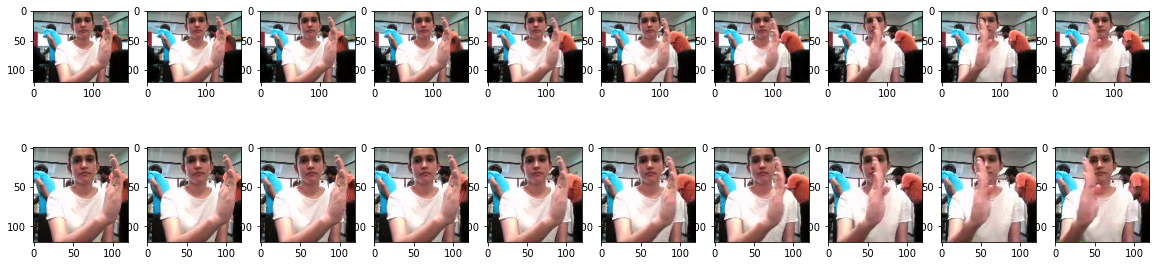

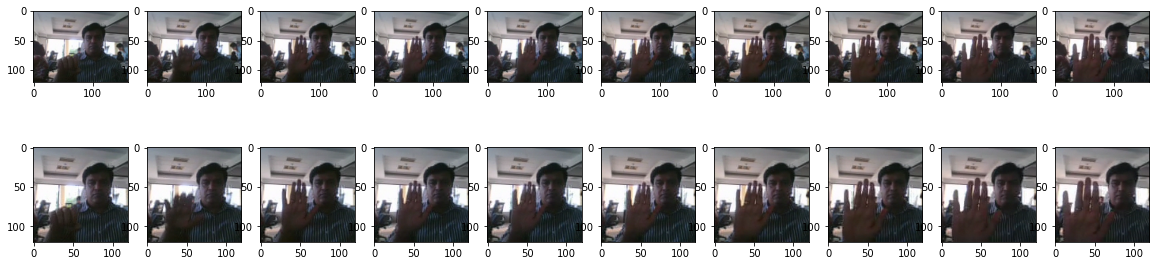

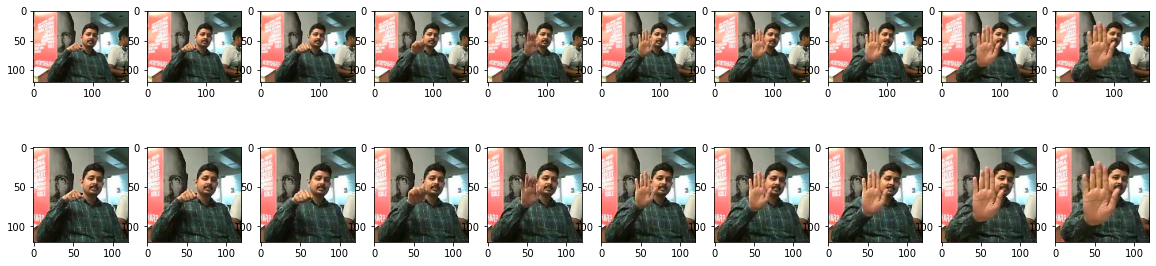

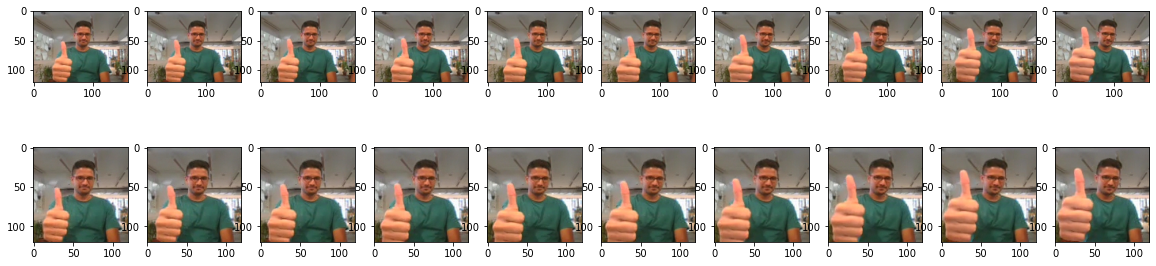

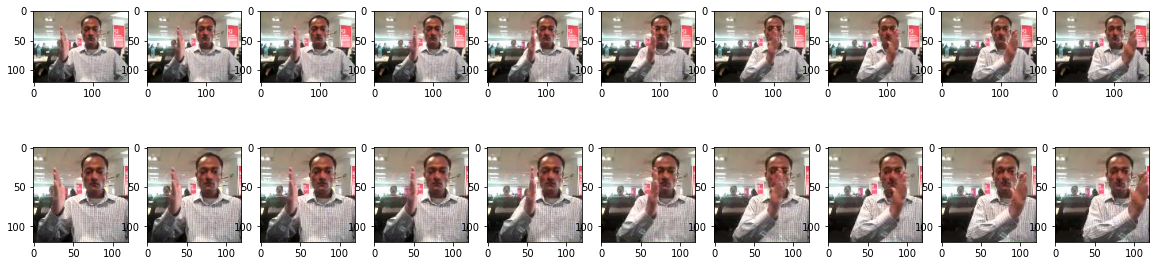

In [34]:
#testing generative
test_gen = generator(train_folder, train_doc, 5, is_train = True, augmentation=False, debug = True)
xx = next(test_gen)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [35]:
curr_dt_time = datetime.datetime.now() #gives us the current date and time
train_path = train_folder
val_path =  val_folder

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('validation sequences =', num_val_sequences)

num_epochs = 50
print ('epochs =', num_epochs)

training sequences = 663
validation sequences = 100
epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
#input shape so thta we can pass to our models
input_shape = (len(seq_idx), dim_x, dim_y, 3)
# using seed so that data wont drastically change
np.random.seed(30)

# MODEL 1- CONV3D

In [12]:
#using sequential model
model = Sequential()

#using relu function instead of sigmoid beacuse It avoids the vanishing gradient 
#problem since it has a constant gradient of 1 for all the positive inputs.
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))

#adding maxpooling to reduce the spatial dimensions
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#to reduce the internal covariate shift and to improve the training of the CNN.
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

#using flattening so that we can give to fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

#for the output layer we are using softmax beacuse our output contains more than one class which is multi-class classification
model.add(Dense(5, activation='softmax'))

In [13]:
# we are using an adam optimizer because it reduces the loss function while training the neural networks
# SparseCategoricalCrossentropy is used for representing as a single index value rather than a one-hot encoded vector
# Accuracy metric to track during training
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# summary shows us all the output shape and parameters used
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 8, 118, 118,    │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 6, 116, 116,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 3, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 58, 58, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 1, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 1, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 28, 28, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 1, 26, 26, 256) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 13, 13, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 1, 11, 11, 512) │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 1, 9, 9, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 4, 4, 512)   │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,317,701 (31.73 MB)

 Trainable params: 8,314,757 (31.72 MB)

 Non-trainable params: 2,944 (11.50 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath ='D:/'+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto',save_freq="epoch",
    initial_value_threshold=None)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks_list = [checkpoint,LR]

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.3965 - loss: 2.5292 
Epoch 1: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00001-2.09347-0.46577-16.71396-0.19531.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 263s 13s/step - categorical_accuracy: 0.3996 - loss: 2.5094 - val_categorical_accuracy: 0.1953 - val_loss: 16.7140 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.7247 - loss: 0.7259
Epoch 2: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00002-0.71046-0.72917-3.07103-0.11719.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 174s 8s/step - categorical_accuracy: 0.7249 - loss: 0.7252 - val_categorical_accuracy: 0.1172 - val_loss: 3.0710 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.8465 - loss: 0.4303
Epoch 3: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00003-0.43792-0.82887-2.72293-0.17188.weights.h5
21/21 ━━━━━━━━━━━━━━━━

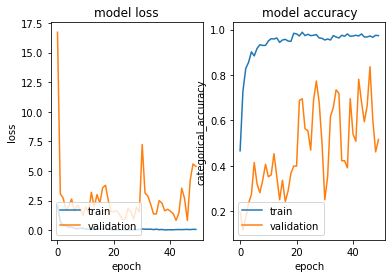

In [19]:
def plot_history(history):
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history['loss'])
    ax1 = plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history['categorical_accuracy'])
    ax2 = plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')

plot_history(history)

# MODEL 2-Adding DropOut Layers

In [20]:
#using sequential model
model = Sequential()

#using relu function instead of sigmoid beacuse It avoids the vanishing gradient 
#problem since it has a constant gradient of 1 for all the positive inputs.
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
#adding maxpooling to reduce the spatial dimensions
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#to reduce the internal covariate shift and to improve the training of the CNN.
model.add(BatchNormalization())
#dropouts are used beacuse they improve model performance and reduce overfitting
model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dropout(0.5))

#using flattening so that we can give to fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
#for the output layer we are using softmax beacuse our output contains more than one class which is multi-class classification
model.add(Dense(5, activation='softmax'))

In [21]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 8, 118, 118,    │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 6, 116, 116,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 3, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 58, 58, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 1, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 1, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 28, 28, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 1, 26, 26, 256) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 1, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 13, 13, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 1, 11, 11, 512) │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 1, 9, 9, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 4, 4, 512)   │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 4, 4, 512)   │             

 Total params: 8,317,701 (31.73 MB)

 Trainable params: 8,314,757 (31.72 MB)

 Non-trainable params: 2,944 (11.50 KB)

None


In [22]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath ='D:/'+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto',save_freq="epoch",
    initial_value_threshold=None)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks_list = [checkpoint,LR]

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3516 - loss: 2.3635
Epoch 1: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00001-2.31593-0.37351-2.54192-0.17188.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - categorical_accuracy: 0.3526 - loss: 2.3614 - val_categorical_accuracy: 0.1719 - val_loss: 2.5419 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5026 - loss: 1.5734
Epoch 2: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00002-1.46674-0.50149-2.79316-0.20312.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 171s 8s/step - categorical_accuracy: 0.5025 - loss: 1.5685 - val_categorical_accuracy: 0.2031 - val_loss: 2.7932 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.6104 - loss: 0.9827
Epoch 3: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00003-0.99127-0.60268-2.48612-0.13281.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 

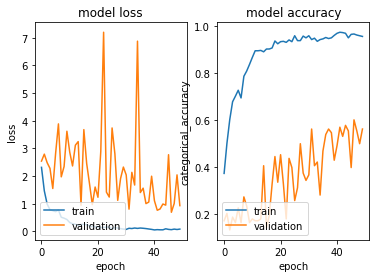

In [27]:
plot_history(history)

# MODEL 3-TimeDistributed+dense layer

In [28]:
#using sequential model
model = Sequential()
# allows to apply a layer to every temporal slice of an input. Every input should be at least 3D
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
#Downsamples the input along its spatial dimensions  by taking the average value over an input window 
model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
#to reduce the internal covariate shift and to improve the training of the CNN.
model.add(BatchNormalization())
#for the output layer we are using softmax beacuse our output contains more than one class which is multi-class classification
model.add(Dense(5, activation='softmax'))

In [29]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 118, 118,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 59, 59, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 10, 59, 59, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 57, 57, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 26, 26,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 13, 13,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 13, 13,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,477 (505.77 KB)

 Trainable params: 128,517 (502.02 KB)

 Non-trainable params: 960 (3.75 KB)

None


In [30]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath ='D:/'+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto',save_freq="epoch",
    initial_value_threshold=None)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks_list = [checkpoint,LR]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [34]:
#fit loads the data into memory
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - categorical_accuracy: 0.4178 - loss: 1.5468 
Epoch 1: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00001-1.31778-0.47321-1.25163-0.14062.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 509s 24s/step - categorical_accuracy: 0.4203 - loss: 1.5364 - val_categorical_accuracy: 0.1406 - val_loss: 1.2516 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - categorical_accuracy: 0.6057 - loss: 0.9675 
Epoch 2: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00002-0.95284-0.59226-1.25231-0.18750.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 523s 25s/step - categorical_accuracy: 0.6051 - loss: 0.9669 - val_categorical_accuracy: 0.1875 - val_loss: 1.2523 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - categorical_accuracy: 0.7041 - loss: 0.7293 
Epoch 3: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00003-0.77270-0.67560-1.30150-0.13281.weights.h5
21/21 ━━━━━━━━━━━━━

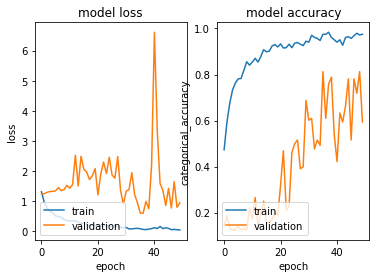

In [35]:
plot_history(history)

# MODEL 4-TimeDistributed+GRU

In [40]:
#using sequential model
model = Sequential()
# allows to apply a layer to every temporal slice of an input. Every input should be at least 3D
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
#to use gating mechanisms to selectively update the hidden state of the network at each time step. 
model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [41]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ (None, 10, 118, 118,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 59, 59, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 59, 59, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 57, 57, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 10, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 10, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 10, 64)         │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,845 (390.02 KB)

 Trainable params: 99,269 (387.77 KB)

 Non-trainable params: 576 (2.25 KB)

None


In [42]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [43]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath ='D:/'+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto',save_freq="epoch",
    initial_value_threshold=None)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks_list = [checkpoint,LR]

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [45]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - categorical_accuracy: 0.3934 - loss: 1.4645 
Epoch 1: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00001-1.26317-0.45982-1.24746-0.17969.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 541s 25s/step - categorical_accuracy: 0.3964 - loss: 1.4554 - val_categorical_accuracy: 0.1797 - val_loss: 1.2475 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - categorical_accuracy: 0.5495 - loss: 1.0371 
Epoch 2: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00002-0.98705-0.57589-1.24619-0.19531.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 522s 25s/step - categorical_accuracy: 0.5507 - loss: 1.0348 - val_categorical_accuracy: 0.1953 - val_loss: 1.2462 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - categorical_accuracy: 0.6328 - loss: 0.8445 
Epoch 3: saving model to D:/model_init_2024-04-3016_04_21.917433/model-00003-0.83444-0.63988-1.24293-0.17188.weights.h5
21/21 ━━━━━━━━━━━━━

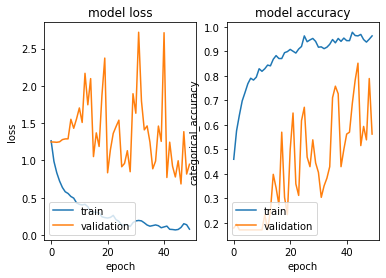

In [47]:
plot_history(history)

# MODEL 5-TimeDistributed+LSTM2D(Final Model)

In [12]:
#using sequential model
model = Sequential()
batch_size = 50
model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())

model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [13]:
batch_size=8
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath ='D:/'+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq="epoch",
   initial_value_threshold=None)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks_list = [checkpoint,LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 118, 118,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 118, 118,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 116, 116,   │         1,168 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 116, 116,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 114, 114, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 114, 114, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 114, 114, 64)   │           576 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 114, 114, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,781 (53.83 KB)

 Trainable params: 13,589 (53.08 KB)

 Non-trainable params: 192 (768.00 B)

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3755 - loss: 1.4996
Epoch 1: saving model to D:/model_init_2024-05-0315_22_38.750205/model-00001-1.39195-0.42620-1.55204-0.14423.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - categorical_accuracy: 0.3761 - loss: 1.4984 - val_categorical_accuracy: 0.1442 - val_loss: 1.5520 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4909 - loss: 1.1800
Epoch 2: saving model to D:/model_init_2024-05-0315_22_38.750205/model-00002-1.13563-0.52560-1.51271-0.20192.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - categorical_accuracy: 0.4913 - loss: 1.1794 - val_categorical_accuracy: 0.2019 - val_loss: 1.5127 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5855 - loss: 0.9948
Epoch 3: saving model to D:/model_init_2024-05-0315_22_38.750205/model-00003-1.02157-0.57229-1.51825-0.28846.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - 

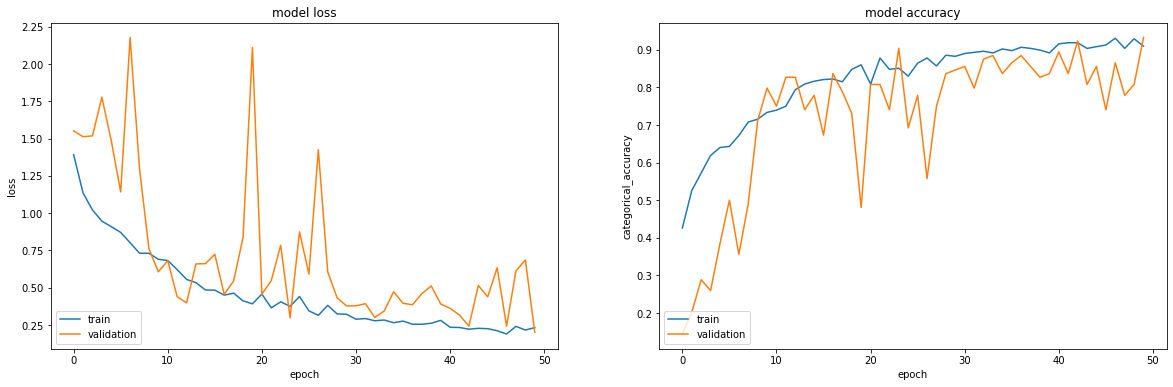

In [44]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')